In [1]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
import sklearn
from __future__ import print_function
import librosa
import numpy as np
import matplotlib.pyplot as plt
from librosa import display,core
from dtw import dtw
from numpy import linalg as LA
from math import sqrt
from scipy import stats
from sklearn import svm
from sklearn.svm import SVR
from mlxtend.plotting import plot_decision_regions
import matplotlib.patches as mpatches
from sklearn.model_selection import cross_val_predict, cross_val_score,cross_validate
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import StratifiedKFold

from collections import Counter

from imblearn.over_sampling import RandomOverSampler
#%matplotlib inline

In [2]:
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import os

def createTrainingData(start, end):
    samples = []
    telangana_dir = 'audio/Telangana'
    coastal_dir = 'audio/Coastal'
    rayalseema_dir = 'audio/Rayalseema'
    
    regions = {
        'Telangana': telangana_dir,
        'Coastal': coastal_dir,
        'Rayalseema':rayalseema_dir
    }

    for region, region_dir in regions.items():
        if region == 'Telangana':
            file_range = range(239, 357)
        elif region == 'Rayalseema':
            file_range = range(116, 215)
        elif region == 'Coastal':
            file_range = range(1, 102)  # Assuming audio files in Coastal are named from '1.wav' to '101.wav'

        for i in file_range:
            ind = 0
            try:
                file_path = os.path.join(region_dir, f"{i}.wav")
                a, s = librosa.load(file_path)
            except:
                ind = 1

            if ind == 0:
                mfcc = librosa.feature.mfcc(y=a, sr=s)
                temp = mfcc.T[1][start:end]
                for frame in range(10, 50):
                    temp = np.concatenate((temp, mfcc.T[frame][start:end]))
                samples.append([temp, region])

    print(len(samples))
    X = [i[0] for i in samples]
    Y = [j[1] for j in samples]
    return X, Y

data, label = createTrainingData(1, 19)
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)


C:\Users\Lavanya Tetakali\AppData\Local\Temp\ipykernel_23464\4124688655.py:30: UserWarning: PySoundFile failed. Trying audioread instead.
  a, s = librosa.load(file_path)
C:\Users\Lavanya Tetakali\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


317


In [3]:
X_train, X_test, y_train, y_test  = train_test_split(data,label)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[('Coastal', 87), ('Rayalseema', 87), ('Telangana', 87)]


In [4]:
def predict(X,Y,Z):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X,Y)
    prediction = knn.predict(Z)
    scores = cross_val_score(knn,data,label)
    print(scores.mean())
    return (prediction)

def printPrediction(prediction,actual_label):
    print("1 -> Telangana, 0-> Coastal, 2-> Rayalseema\n")
    for i in range(len(prediction)):
        print("Actual ->",actual_label[i]," Prediction ->",prediction[i])

def accuracy(prediction,actual):
    count=0
    l=len(prediction)
    for i in range(l):
        if(prediction[i]==actual[i]):
            count+=1
    return count/l*100

In [5]:
s= time.time()
pred = predict(X_resampled,y_resampled,X_test)
#printPrediction(prediction,y_train)
print(time.time()-s)
e = accuracy(pred,y_test)
print("\nAccuracy:",e)

0.7319444444444444
0.7249243259429932

Accuracy: 85.0


In [6]:
confusion_matrix(y_test, pred)


array([[24,  1,  3],
       [ 0, 21,  0],
       [ 0,  8, 23]], dtype=int64)

In [7]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, pred)

# Access the elements of the confusion matrix
tn = conf_matrix[0, 0]  # True negatives
fp = conf_matrix[0, 1]  # False positives
fn = conf_matrix[1, 0]  # False negatives
tp = conf_matrix[1, 1]  # True positives

In [8]:
precision = round(tp/(tp+fp),4)
recall = round(tp/(tp+fn),4)
fmeasure = round(2*((precision*recall)/(precision+recall)),4)
rej = round(tn/(tn+fp),4)
acc = round((tn+tp)/(tn+tp+fp+fn),4)

In [9]:
print(precision,recall,fmeasure,rej,acc)

0.9545 1.0 0.9767 0.96 0.9783


In [10]:
knn = KNeighborsClassifier(5)
scores = cross_val_score(knn, data, label, cv=10, scoring='f1_macro')
scores.mean(),scores.std()   

(0.7406205702821331, 0.1392985916890482)

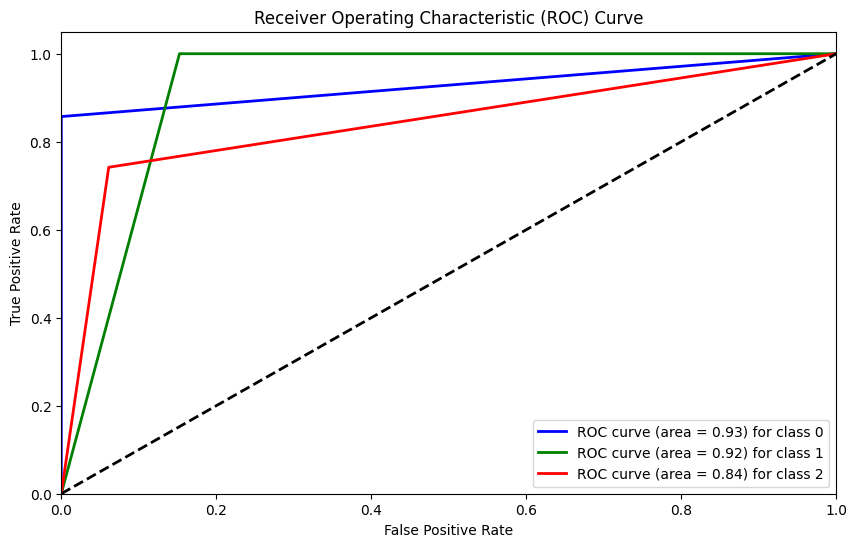

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming 'y_test' and 'pred' contain your actual labels and predicted labels
# Convert labels to binary (0 and 1) for one-vs-all ROC AUC curve
y_test_bin = label_binarize(y_test, classes=['Coastal', 'Rayalseema', 'Telangana'])
pred_bin = label_binarize(pred, classes=['Coastal', 'Rayalseema', 'Telangana'])

n_classes = y_test_bin.shape[1]

# Initialize variables to store the ROC curve and AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC AUC curves
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [12]:
import librosa
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Load the audio file
file_path = 'audio/Coastal/1.wav'
audio_data, sample_rate = librosa.load(file_path)

# Extract MFCC features from the audio file
mfcc = librosa.feature.mfcc(y=audio_data, sr=sample_rate)
# Define the start and end indices for the features you want to consider
start = 1  # Define your start index
end = 19  # Define your end index

features = []
temp = mfcc.T[1][start:end]
for frame in range(10, 50):
    temp = np.concatenate((temp, mfcc.T[frame][start:end]))
features.append(temp)

# Debug: Print the extracted features to check their values
#print("Extracted Features:", features)

# Assuming you have already loaded your training data and created X_resampled and y_resampled
# Define and fit your KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_resampled, y_resampled)

# Now you can use the trained KNN classifier to predict the class of the audio file
predicted_class = knn.predict(features)

# Print the predicted class
print("Predicted Class:", predicted_class)



Predicted Class: ['Coastal']


In [13]:
from sklearn.metrics import classification_report

# Assuming 'y_test' contains the true labels and 'pred' contains the predicted labels
report = classification_report(y_test, pred)

# Print the classification report
print(report)


              precision    recall  f1-score   support

     Coastal       1.00      0.86      0.92        28
  Rayalseema       0.70      1.00      0.82        21
   Telangana       0.88      0.74      0.81        31

    accuracy                           0.85        80
   macro avg       0.86      0.87      0.85        80
weighted avg       0.88      0.85      0.85        80

